In [1]:



import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from lime import lime_tabular


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler





data = pd.read_csv("bs140513_032310.csv")
data.head(5)

step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


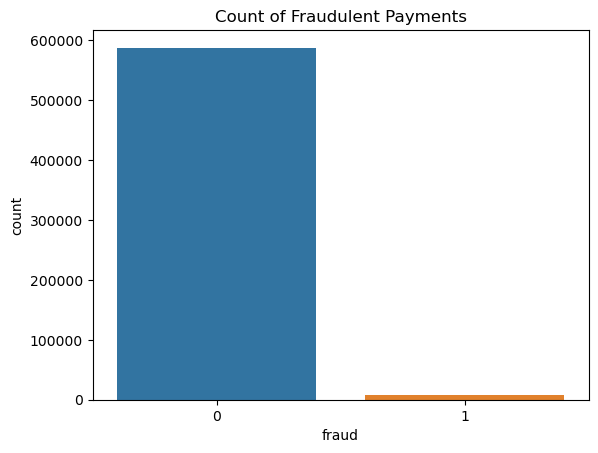

Number of normal examples:  587443
Number of fradulent examples:  7200


In [3]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

In [4]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


In [5]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

Fraudulent  Non-Fraudulent  Percent(%)
category                                                        
'es_transportation'              NaN       26.958187    0.000000
'es_food'                        NaN       37.070405    0.000000
'es_hyper'                169.255429       40.037145    4.591669
'es_barsandrestaurants'   164.092667       41.145997    1.882944
'es_contents'                    NaN       44.547571    0.000000
'es_wellnessandbeauty'    229.422535       57.320219    4.759380
'es_fashion'              247.008190       62.347674    1.797335
'es_leisure'              300.286878       73.230400   94.989980
'es_otherservices'        316.469605       75.685497   25.000000
'es_sportsandtoys'        345.366811       88.502738   49.525237
'es_tech'                 415.274114       99.924638    6.666667
'es_health'               407.031338      103.737228   10.512614
'es_hotelservices'        421.823339      106.548545   31.422018
'es_home'                 457.484834      113.338409   15.206445
'es_travel'              2660.802872      669.025533   79.395604

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


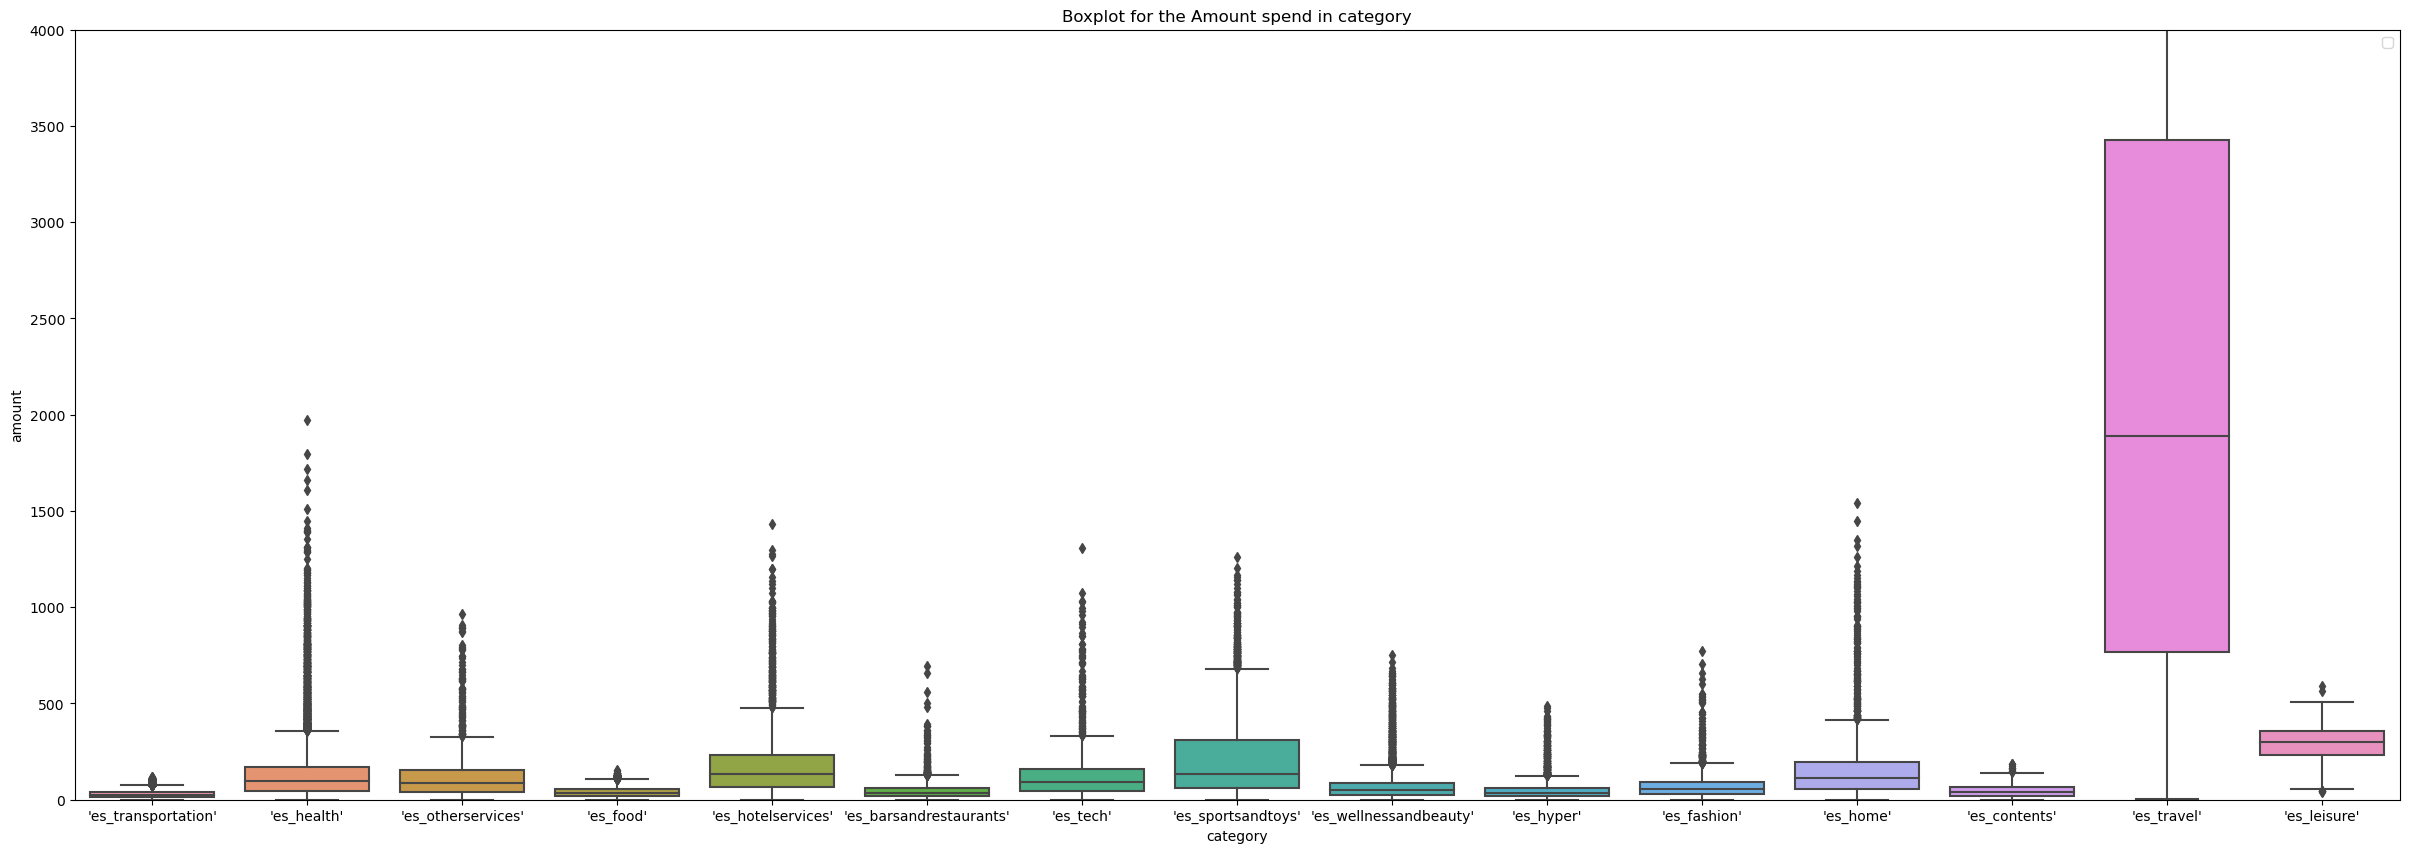

In [6]:
# Plot boxplot of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

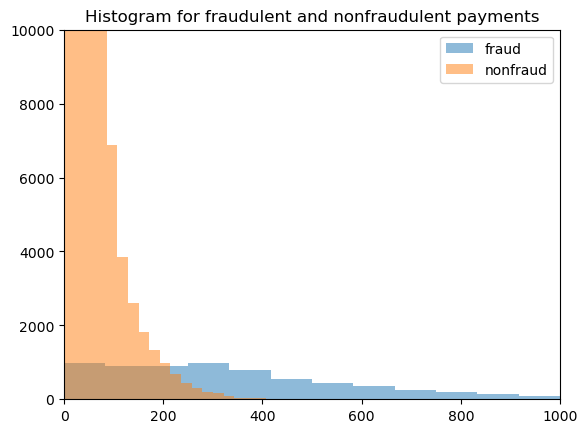

In [7]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [8]:
print(
    (data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}
                                                                  ).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


In [9]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [10]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

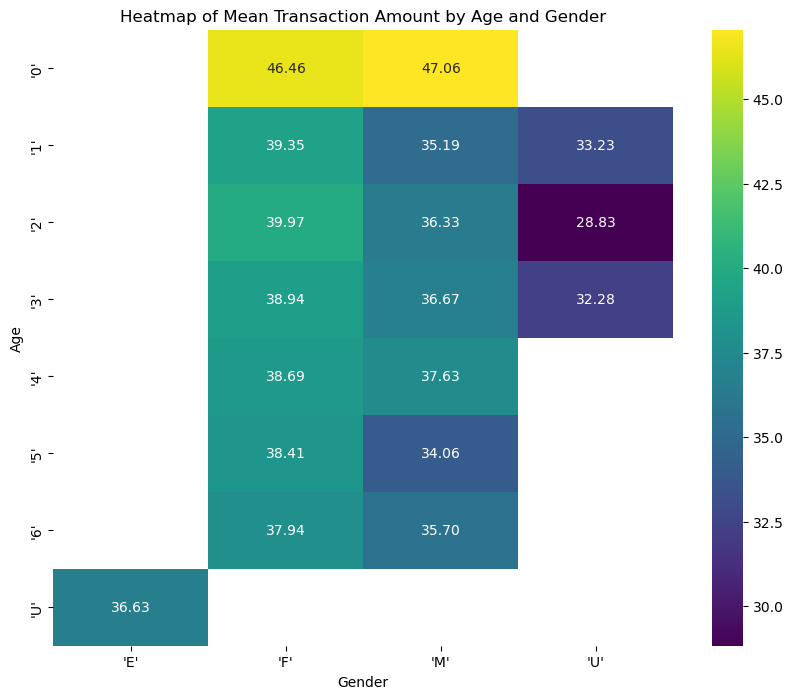

In [11]:
# Grouping data by 'age' and 'gender' and calculating the mean 'amount'
grouped_data = data_reduced.groupby(['age', 'gender'])['amount'].mean().unstack()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(grouped_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Mean Transaction Amount by Age and Gender')
plt.ylabel('Age')
plt.xlabel('Gender')
plt.show()

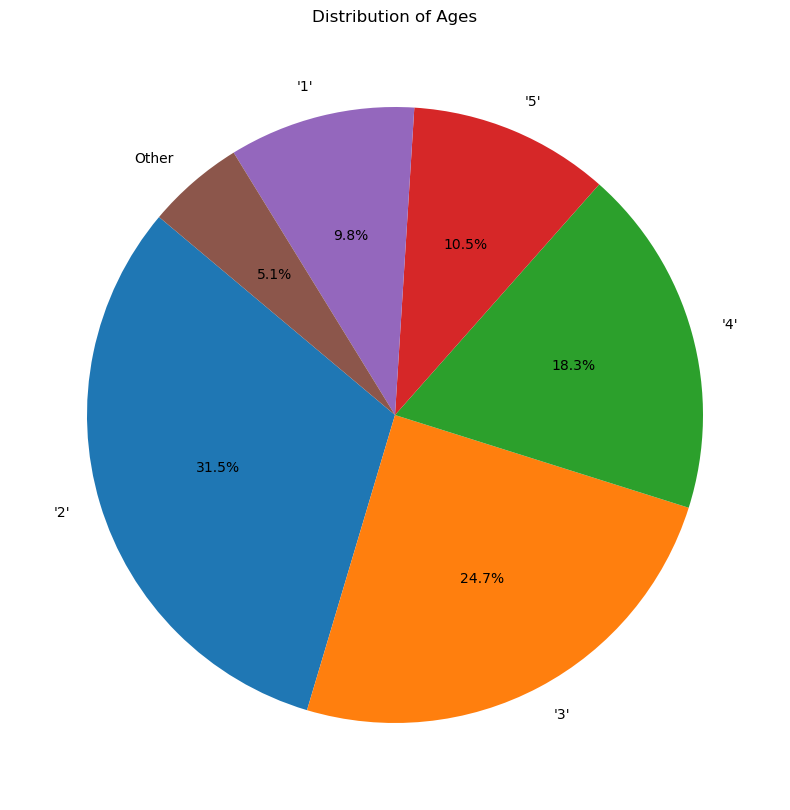

In [12]:
# Counting the occurrences of each age category
age_counts = data_reduced['age'].value_counts()

# Combine smaller slices into an 'Other' category if they constitute less than a threshold (e.g., 5%)
threshold = 0.05  # 5%
small_categories = age_counts[age_counts / age_counts.sum() < threshold]
big_categories = age_counts[age_counts / age_counts.sum() >= threshold]

# If there are any small categories to combine
if len(small_categories) > 0:
    age_counts = big_categories.append(pd.Series(small_categories.sum(), index=['Other']))

# Plotting the pie chart
plt.figure(figsize=(12, 10))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ages')
plt.show()

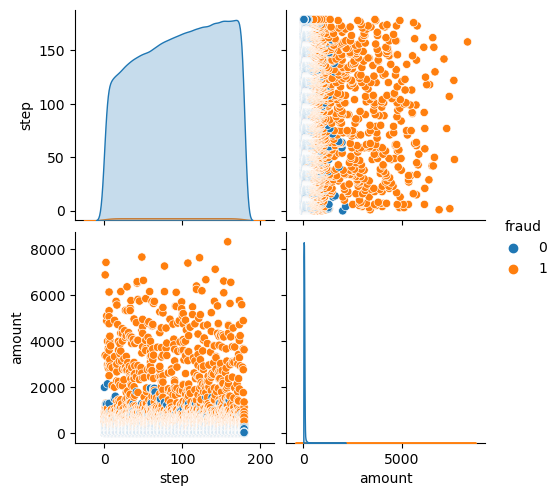

In [13]:
# Convert categorical data to category types for better plotting
data_reduced['customer'] = data_reduced['customer'].astype('category')
data_reduced['age'] = data_reduced['age'].astype('category')
data_reduced['gender'] = data_reduced['gender'].astype('category')
data_reduced['category'] = data_reduced['category'].astype('category')
data_reduced['fraud'] = data_reduced['fraud'].astype('category')

# Visualizing the pairplot with 'fraud' as the hue to differentiate between fraudulent and non-fraudulent transactions
sns.pairplot(data_reduced, hue='fraud')
plt.show()

In [14]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

step       customer  age gender  merchant             category  amount  \
0     0  'C1093826151'  '4'    'M'        30  'es_transportation'    4.55   
1     0   'C352968107'  '2'    'M'        30  'es_transportation'   39.68   
2     0  'C2054744914'  '4'    'F'        18  'es_transportation'   26.89   
3     0  'C1760612790'  '3'    'M'        30  'es_transportation'   17.25   
4     0   'C757503768'  '5'    'M'        30  'es_transportation'   35.72   

  fraud  
0     0  
1     0  
2     0  
3     0  
4     0

In [15]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step       customer  age gender  merchant             category  amount
0     0  'C1093826151'  '4'    'M'        30  'es_transportation'    4.55
1     0   'C352968107'  '2'    'M'        30  'es_transportation'   39.68
2     0  'C2054744914'  '4'    'F'        18  'es_transportation'   26.89
3     0  'C1760612790'  '3'    'M'        30  'es_transportation'   17.25
4     0   'C757503768'  '5'    'M'        30  'es_transportation'   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [16]:
y[y==1].count()

7200

In [17]:
categorical_columns = ['customer', 'age', 'gender', 'merchant', 'category']

# Convert categorical columns using LabelEncoder
le = LabelEncoder()
for col in categorical_columns:
    data_reduced[col] = le.fit_transform(data_reduced[col])

# Check for any remaining non-numeric columns
non_numeric_cols = data_reduced.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found: {non_numeric_cols}")
    for col in non_numeric_cols:
        print(f"Unique values in {col}: {data_reduced[col].unique()}")
else:
    print("No non-numeric columns found.")
    
# Separate features and target
X = data_reduced.drop('fraud', axis=1)
y = data_reduced['fraud']

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Value counts of the resampled target variable
y_res_value_counts = pd.Series(y_res).value_counts()

print(y_res_value_counts)



No non-numeric columns found.
0    587443
1    587443
Name: fraud, dtype: int64


In [18]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

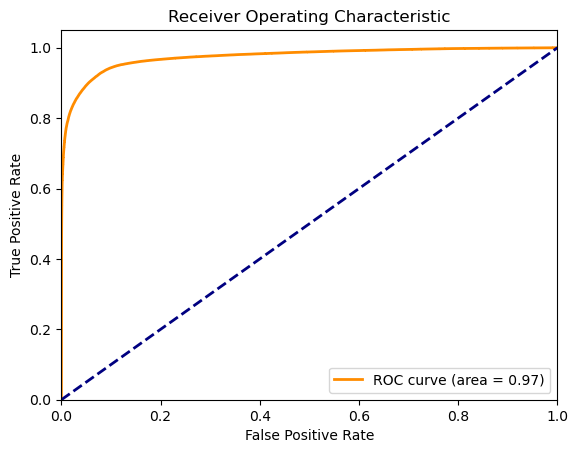

In [19]:
# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

# Get the prediction scores
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


In [21]:
def plot_roc_auc(y_true, y_scores):
    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


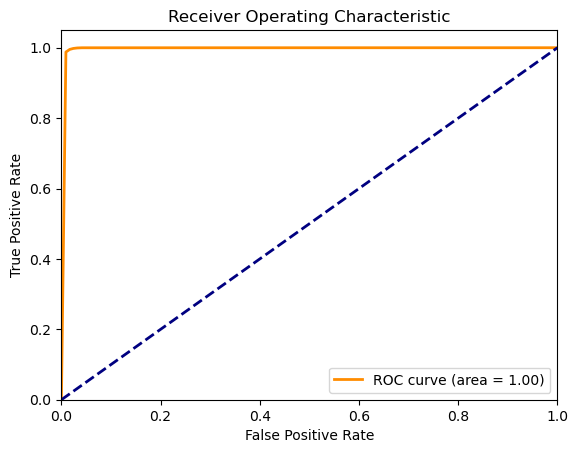

In [22]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


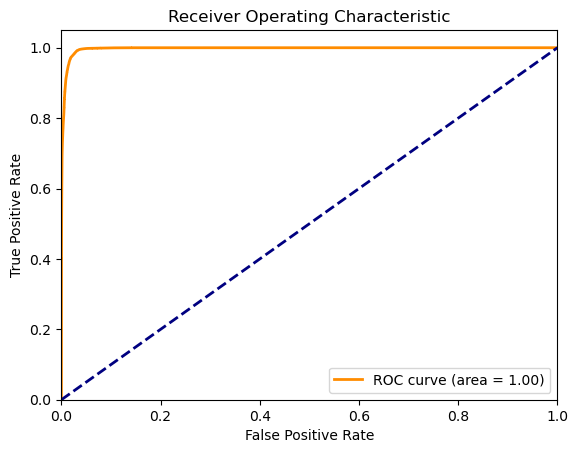

In [23]:
#Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174100   2133]
 [   787 175446]]


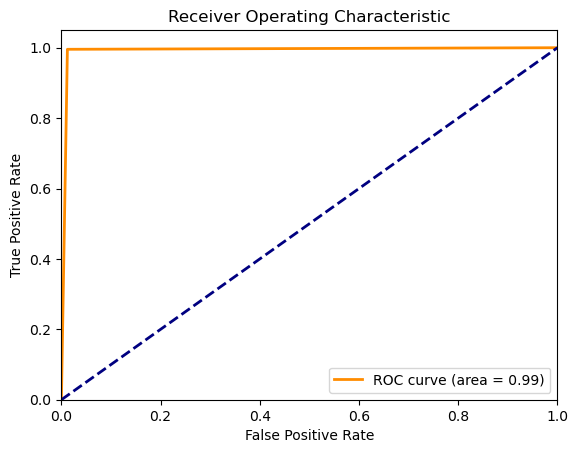

In [24]:

#XGBoost Classifer
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                            objective="binary:hinge", booster='gbtree', 
                            n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                            subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished


Classification Report for Ensemble: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of Ensemble: 
 [[173364   2869]
 [   302 175931]]


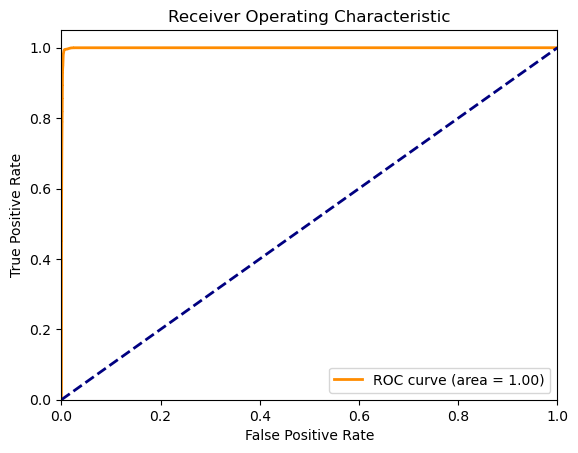

In [25]:
# Create a VotingClassifier for an ensemble of models
# 'soft' voting takes the probabilities into account
ensemble = VotingClassifier(estimators=[
    ('knn', knn), 
    ('rf', rf_clf), 
    ('xgb', XGBoost_CLF)], 
    voting='soft')

# Fit the ensemble classifier to the training data
ensemble.fit(X_train, y_train)

# Predict on the test data
y_ensemble_pred = ensemble.predict(X_test)
y_ensemble_proba = ensemble.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report for Ensemble: \n", classification_report(y_test, y_ensemble_pred))
print("Confusion Matrix of Ensemble: \n", confusion_matrix(y_test, y_ensemble_pred))
plot_roc_auc(y_test, y_ensemble_proba)

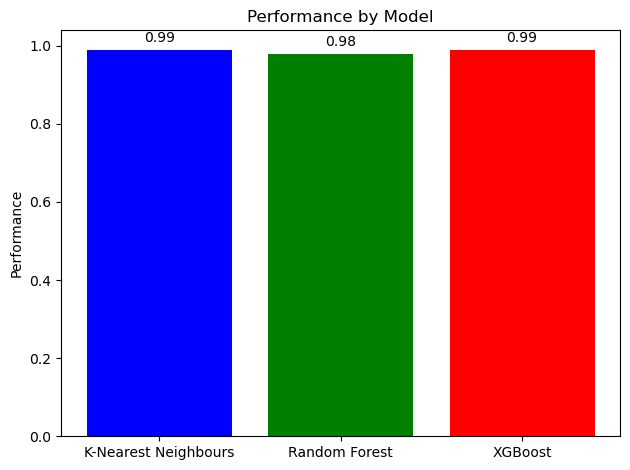

In [26]:

# Names of the models
models = ['K-Nearest Neighbours', 'Random Forest', 'XGBoost']

# Replace these with your actual model performance metrics (e.g., accuracy)
performance = [0.99, 0.98, 0.99]

#bar chart
fig, ax = plt.subplots()
bars = ax.bar(models, performance, color=['blue', 'green', 'red'])

ax.set_ylabel('Performance')
ax.set_title('Performance by Model')
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)

# Label with the exact performance metric above each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


In [27]:
#1d CNN
#LIME to performe exlainable AI for the best model

In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)




In [29]:
X_train.shape

(822420, 7)

In [30]:
from sklearn.utils import shuffle
train_labels=np.array(y_train)
train_samples=np.array(X_train)
train_labels,train_samples=shuffle(train_labels,train_samples)

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_samples=scaler.fit_transform(train_samples)

In [32]:
X_train=scaled_train_samples
y_train=train_labels

In [33]:
X_train.shape

(822420, 7)

In [34]:


# Define the 1D CNN model
model = Sequential([
        Dense(units=16, input_shape=(X_train.shape[1],)),
      
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

    





Epoch 1/100


10281/10281 [==============================] - 15s 1ms/step - loss: 0.1395 - accuracy: 0.9521 - val_loss: 0.0991 - val_accuracy: 0.9664
Epoch 2/100
10281/10281 [==============================] - 11s 1ms/step - loss: 0.0975 - accuracy: 0.9676 - val_loss: 0.0939 - val_accuracy: 0.9689
Epoch 3/100
10281/10281 [==============================] - 13s 1ms/step - loss: 0.0934 - accuracy: 0.9689 - val_loss: 0.0950 - val_accuracy: 0.9671
Epoch 4/100
10281/10281 [==============================] - 13s 1ms/step - loss: 0.0904 - accuracy: 0.9697 - val_loss: 0.0880 - val_accuracy: 0.9699
Epoch 5/100
10281/10281 [==============================] - 12s 1ms/step - loss: 0.0879 - accuracy: 0.9704 - val_loss: 0.0877 - val_accuracy: 0.9703
Epoch 6/100
10281/10281 [==============================] - 11s 1ms/step - loss: 0.0858 - accuracy: 0.9709 - val_loss: 0.0846 - val_accuracy: 0.9705
Epoch 7/100
10281/10281 [==============================] - 15s 1ms/step - loss: 0.0827 - accuracy: 0.9713 - 

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predictions and Evaluation
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Test Accuracy: 87.94%
11015/11015 [==============================] - 10s 899us/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89    176233
           1       0.95      0.80      0.87    176233

    accuracy                           0.88    352466
   macro avg       0.89      0.88      0.88    352466
weighted avg       0.89      0.88      0.88    352466

Confusion Matrix: 
 [[168828   7405]
 [ 35085 141148]]


In [36]:
# Assuming 'data_reduced' is your DataFrame
print("Dataset shape:", data_reduced.shape)
print("First few rows of the dataset:\n", data_reduced.head())


Dataset shape: (594643, 8)
First few rows of the dataset:
    step  customer  age  gender  merchant  category  amount fraud
0     0       210    4       2        30        12    4.55     0
1     0      2753    2       2        30        12   39.68     0
2     0      2285    4       1        18        12   26.89     0
3     0      1650    3       2        30        12   17.25     0
4     0      3585    5       2        30        12   35.72     0


In [37]:
# Separating features and target
X = data_reduced.drop('fraud', axis=1)
y = data_reduced['fraud']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the index of X_test to avoid indexing issues
X_test = X_test.reset_index(drop=True)

In [38]:
# Extract feature names
feature_names = X.columns.tolist()

# Define class names for the binary classification task
class_names = ['Not Fraud', 'Fraud']

# Instantiate a LIME explainer object
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train), 
    feature_names=feature_names,  
    class_names=class_names,      
    mode='classification'
)

# Define a function to explain a model prediction
def explain_model_prediction(model, instance_idx):
    exp = explainer.explain_instance(
        data_row=X_test.iloc[instance_idx].values, 
        predict_fn=model.predict_proba
    )
    exp.show_in_notebook(show_table=True, show_all=False)

# Choose a sample to explain (ensure this index exists in X_test)
idx_to_explain = 0  # Use the first index as an example

# Your model explanations
print("Explanation for Random Forest Classifier:")
explain_model_prediction(rf_clf, idx_to_explain)

print("\nExplanation for K-Nearest Neighbors:")
explain_model_prediction(knn, idx_to_explain)

print("\nExplanation for XGBoost Classifier:")
explain_model_prediction(XGBoost_CLF, idx_to_explain)

Explanation for Random Forest Classifier:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



Explanation for K-Nearest Neighbors:



Explanation for XGBoost Classifier:
